<h1 style="text-align: center; font-weight: bold;"><u>Import et chargement des données</u></h1>

In [1]:
import sqlite3
from datetime import timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp
from myFonctions import (
    get_cluster_labels,
    validite_M0,
    entrainer_modele,
    comparer_models,
    tracer_stabilite_ari,
    compute_ari_between_periods,
    compute_ks_test_between_periods,
    plot_ari,
    plot_feature_distribution
)
import warnings
from copy import deepcopy

In [2]:
# Chemin vers la base de données SQLite
db_path = 'data/olist.db'

# Créer une connexion à la base de données SQLite
conn = sqlite3.connect(db_path)

In [3]:
query = """
WITH max_date AS (
    SELECT MAX(order_purchase_timestamp) AS global_max_date
    FROM orders
),
customer_orders AS (
    SELECT 
        c.customer_unique_id,
        o.order_id,
        o.order_purchase_timestamp
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
),
payments AS (
    SELECT 
        co.customer_unique_id,
        co.order_id,
        co.order_purchase_timestamp,
        op.payment_value
    FROM customer_orders co
    JOIN order_pymts op ON co.order_id = op.order_id
),
frequencies AS (
    SELECT 
        customer_unique_id,
        COUNT(DISTINCT order_id) AS frequency
    FROM customer_orders
    GROUP BY customer_unique_id
),
rfm AS (
    SELECT 
        p.customer_unique_id,
        p.order_id,
        p.order_purchase_timestamp,
        f.frequency,
        CAST(JULIANDAY(m.global_max_date) - JULIANDAY(p.order_purchase_timestamp) AS INT) AS recency,
        ROUND(p.payment_value, 2) AS monetary
    FROM payments p
    JOIN frequencies f ON p.customer_unique_id = f.customer_unique_id
    CROSS JOIN max_date m
)

SELECT *
FROM rfm
ORDER BY order_purchase_timestamp;

"""

# Ensuite on exécute la requête
df = pd.read_sql_query(query, conn)


<h1 style="text-align: center; font-weight: bold;"><u>Test de validité M0</u></h1>

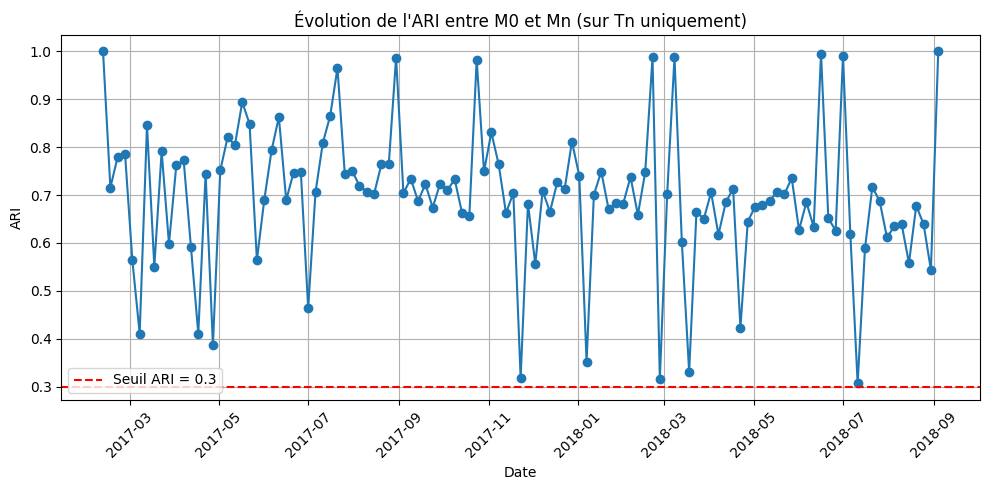

In [5]:
# Conversion des dates
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

df_resultats = validite_M0(
    df,
    date_col='order_purchase_timestamp',
    features=['recency', 'frequency', 'monetary'],
    n_clusters=4,
    pas_jours=5,
    periode_init=0.2,
    seuil_ARI=0.3
)


🔍 Ce qu’on observe :
L’ARI varie fortement dans le temps, oscillant entre 0.3 et 1.0, avec des chutes brutales à certains moments.

Une grande partie des points est au-dessus de 0.6–0.7, indiquant une stabilité raisonnable du clustering.

Quelques chutes nettes sous 0.5, voire proches du seuil 0.3, indiquent des changements importants dans les caractéristiques client.

✅ Ce qu’on peut conclure :
Le modèle de clustering est globalement stable dans le temps, mais il n’est pas complètement robuste aux nouvelles données.

Les baisses ponctuelles de l’ARI pourraient correspondre à des périodes de changement comportemental des clients, de saisonnalité, ou d’arrivée de nouvelles catégories.

Une surveillance continue est nécessaire, et il pourrait être judicieux de réentraîner complètement le modèle à certains moments.

<h1 style="text-align: center; font-weight: bold;"><u>Période optimale de réentraînement</u></h1>

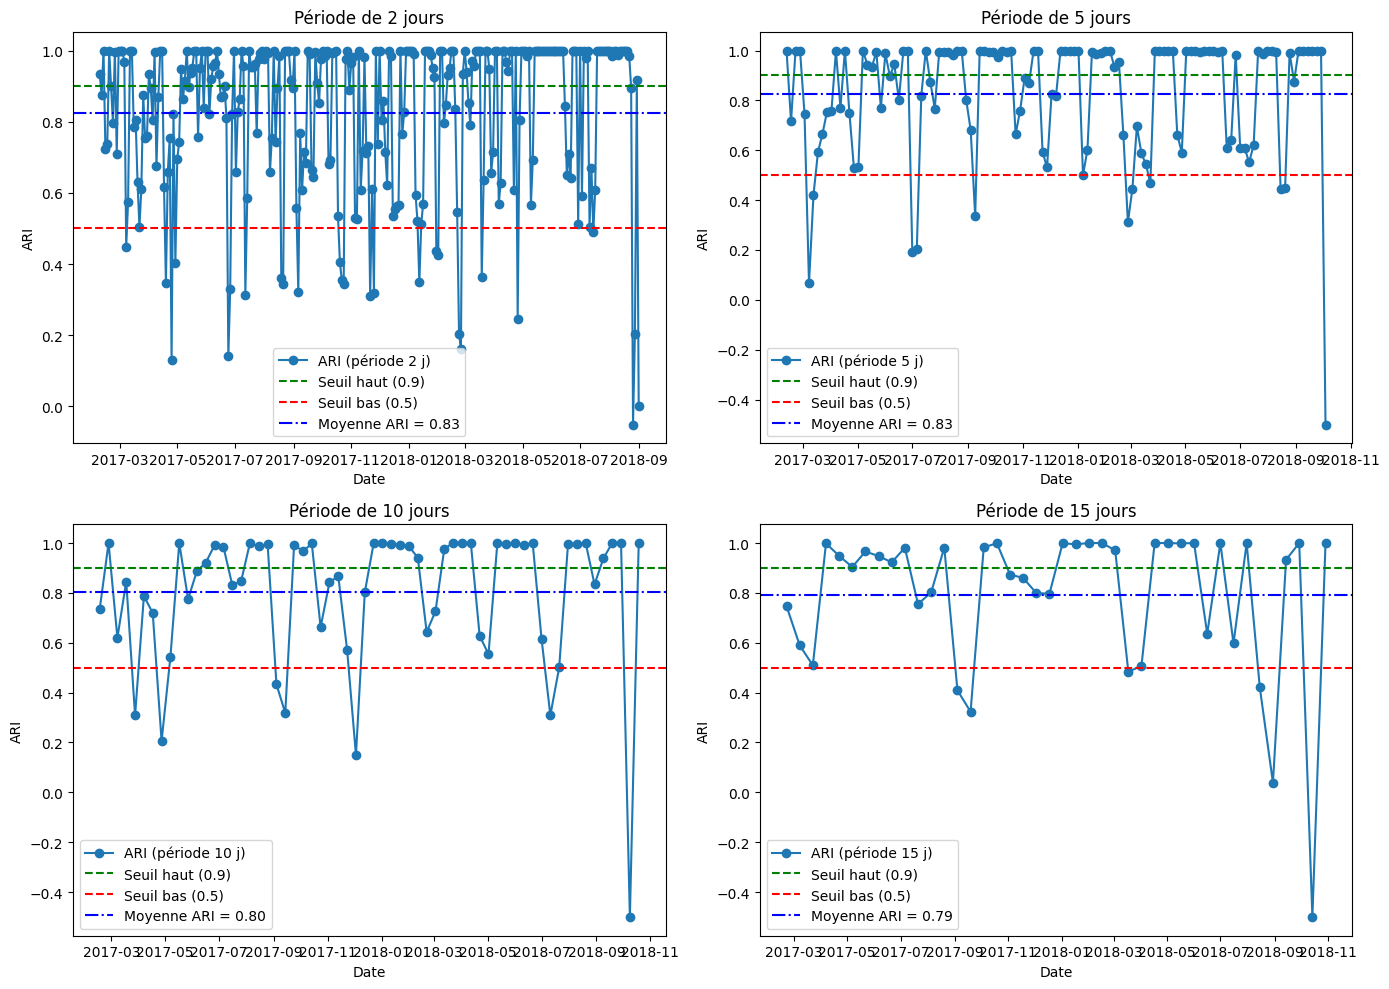

In [6]:
# Appel de la fonction avec dict_res
dict_res = comparer_models(
    df,
    date_col='order_purchase_timestamp',
    features=['recency', 'frequency', 'monetary'],
    n_clusters=4,
    periode_init=0.2,
    pas_jours_list=[2, 5, 10, 15]
)
tracer_stabilite_ari(dict_res)